In [157]:
# ────────────────────────────── 0. Imports ───────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import whisper
import torch
import re
import time
from pathlib import Path
import seaborn as sns
from IPython.display import Audio, display
import soundfile as sf
import librosa
import librosa.display
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [158]:
try:
    from SentimentInferenceModel import SentimentInferenceModel as SentModel
    print("Import successful")
    print(f"SentModel is: {SentModel}")
    
    # Try creating the model with explicit debugging
    print(f"MODEL_DIR path exists: {os.path.exists(MODEL_DIR)}")
    print(f"MODEL_DIR contents: {os.listdir(MODEL_DIR)}")
    
    sentiment_model = SentModel(MODEL_DIR)
    print("Model instantiation successful")
except Exception as e:
    import traceback
    print(f"Error type: {type(e).__name__}")
    print(f"Error details: {str(e)}")
    print("Full traceback:")
    print(traceback.format_exc())

Import successful
SentModel is: <class 'SentimentInferenceModel.SentimentInferenceModel'>
MODEL_DIR path exists: True
MODEL_DIR contents: ['label_cols.json', 'config.json', 'word_index.pkl', 'model.keras', 'opt_thresholds.npy']
Error type: FileNotFoundError
Error details: [Errno 2] Unable to synchronously open file (unable to open file: name = '../models/transformer_sentiment/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Full traceback:


Traceback (most recent call last):
  File "/var/folders/w_/0qjwbm551ls6swp_lf0j1b600000gn/T/ipykernel_35286/2073409235.py", line 10, in <module>
    sentiment_model = SentModel(MODEL_DIR)
  File "/Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/project/notebooks/SentimentInferenceModel.py", line 20, in __init__
    self.model = keras.models.load_model(os.path.join(model_dir, "model.h5"))
  File "/Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py", line 196, in load_model
    return legacy_h5_format.load_model_from_hdf5(
  File "/Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.9/site-packages/keras/src/legacy/saving/legacy_h5_format.py", line 116, in load_model_from_hdf5
    f = h5py.File(filepath, mode="r")
  File "/Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.9/site-packages/h5py/_hl/f

In [159]:
# ────────────────────────────── 1. Setup ───────────────────────────────
# Check GPU availability for Whisper
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define paths
AUDIO_DIR = "../data/audio/samples/"
MODEL_DIR = "../models/transformer_sentiment"  # Path to your saved sentiment model

# RAVDESS emotion codes mapping (based on the provided documentation)
RAVDESS_EMOTIONS = {
    '01': 'neutral',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry'
}

# RAVDESS gender mapping (based on the provided documentation)
RAVDESS_GENDER = {
    '01': 'female',
    '11': 'male'
}

PyTorch CUDA available: False
Using device: cpu


In [160]:
print(f"Current working directory: {os.getcwd()}")
print(f"MODEL_DIR absolute path: {os.path.abspath(MODEL_DIR)}")
print(f"MODEL_DIR exists: {os.path.exists(MODEL_DIR)}")
print(f"MODEL_DIR contents: {os.listdir(MODEL_DIR) if os.path.exists(MODEL_DIR) else 'Directory not found'}")

Current working directory: /Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/project/notebooks
MODEL_DIR absolute path: /Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/project/models/transformer_sentiment
MODEL_DIR exists: True
MODEL_DIR contents: ['label_cols.json', 'config.json', 'word_index.pkl', 'model.keras', 'opt_thresholds.npy']


In [161]:
# ────────────────────────────── 2. Load and Explore Audio Files ─────────────────────
def parse_ravdess_filename(filename):
    """Parse RAVDESS filename to extract metadata based on the format 03-01-[emotion]-01-01-01-[actor].wav"""
    parts = filename.split('.')[0].split('-')
    
    # Based on the naming convention in the documentation
    emotion_code = parts[2]
    actor_code = parts[6]
    
    return {
        'filename': filename,
        'modality': parts[0],  # 03 = speech
        'vocal_channel': parts[1],  # 01 = full sentence
        'emotion_code': emotion_code,
        'emotion': RAVDESS_EMOTIONS.get(emotion_code, 'unknown'),
        'intensity': parts[3],  # 01 = normal intensity
        'statement': parts[4],  # 01 = standard statement
        'repetition': parts[5],  # 01 = 1st repetition
        'actor': actor_code,
        'gender': RAVDESS_GENDER.get(actor_code, 'unknown')
    }

# Get list of audio files and create metadata
audio_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
metadata = [parse_ravdess_filename(file) for file in audio_files]
metadata_df = pd.DataFrame(metadata)

print(f"Found {len(audio_files)} audio files")
display(metadata_df)

Found 8 audio files


,filename,modality,vocal_channel,emotion_code,emotion,intensity,statement,repetition,actor,gender
0,03-01-01-01-01-01-01.wav,03,01,01,neutral,01,01,01,01,female
1,03-01-01-01-01-01-11.wav,03,01,01,neutral,01,01,01,11,male
2,03-01-04-01-01-01-11.wav,03,01,04,sad,01,01,01,11,male
3,03-01-03-01-01-01-01.wav,03,01,03,happy,01,01,01,01,female
4,03-01-04-01-01-01-01.wav,03,01,04,sad,01,01,01,01,female
5,03-01-03-01-01-01-11.wav,03,01,03,happy,01,01,01,11,male
6,03-01-05-01-01-01-01.wav,03,01,05,angry,01,01,01,01,female
7,03-01-05-01-01-01-11.wav,03,01,05,angry,01,01,01,11,male


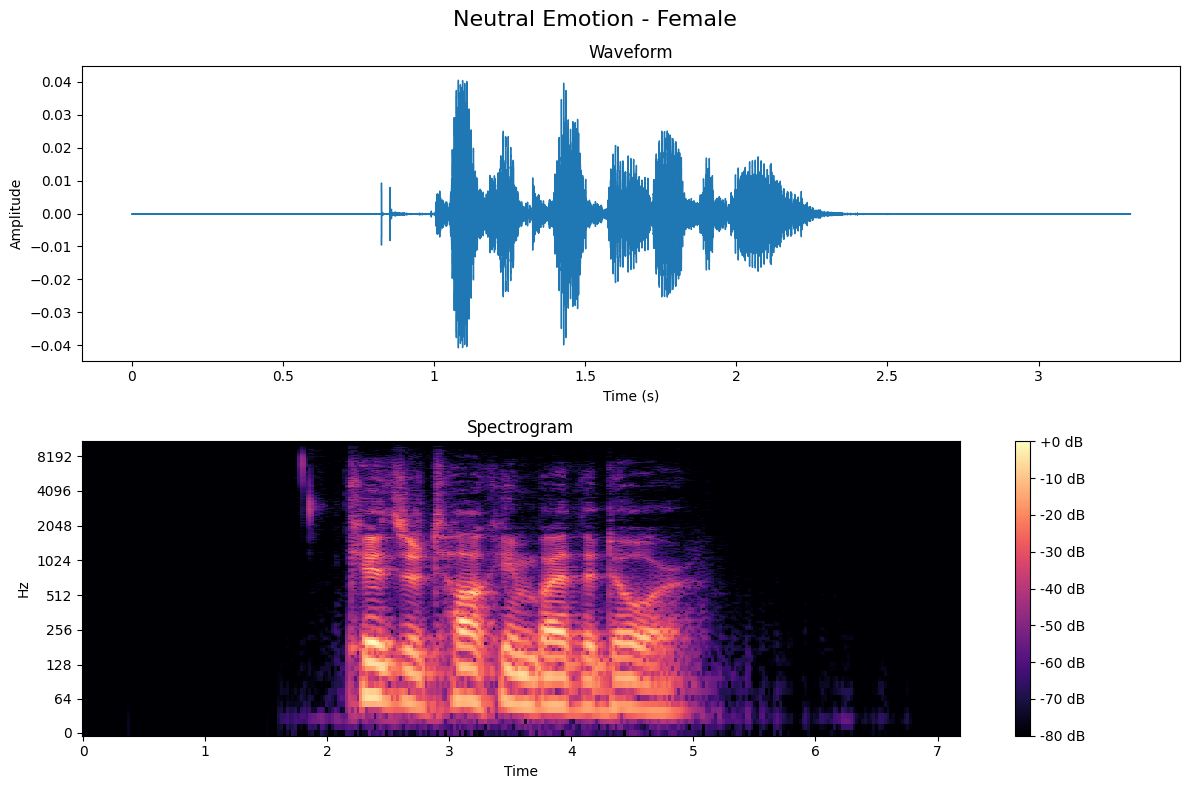

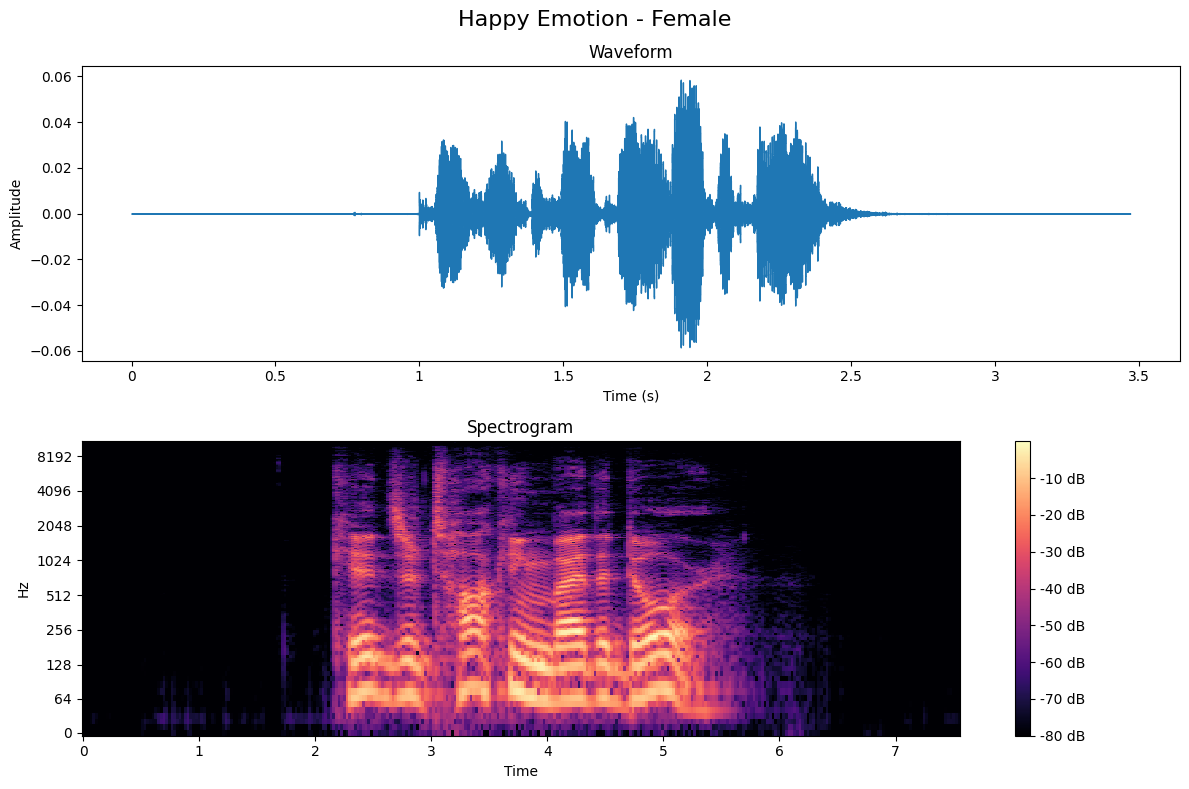

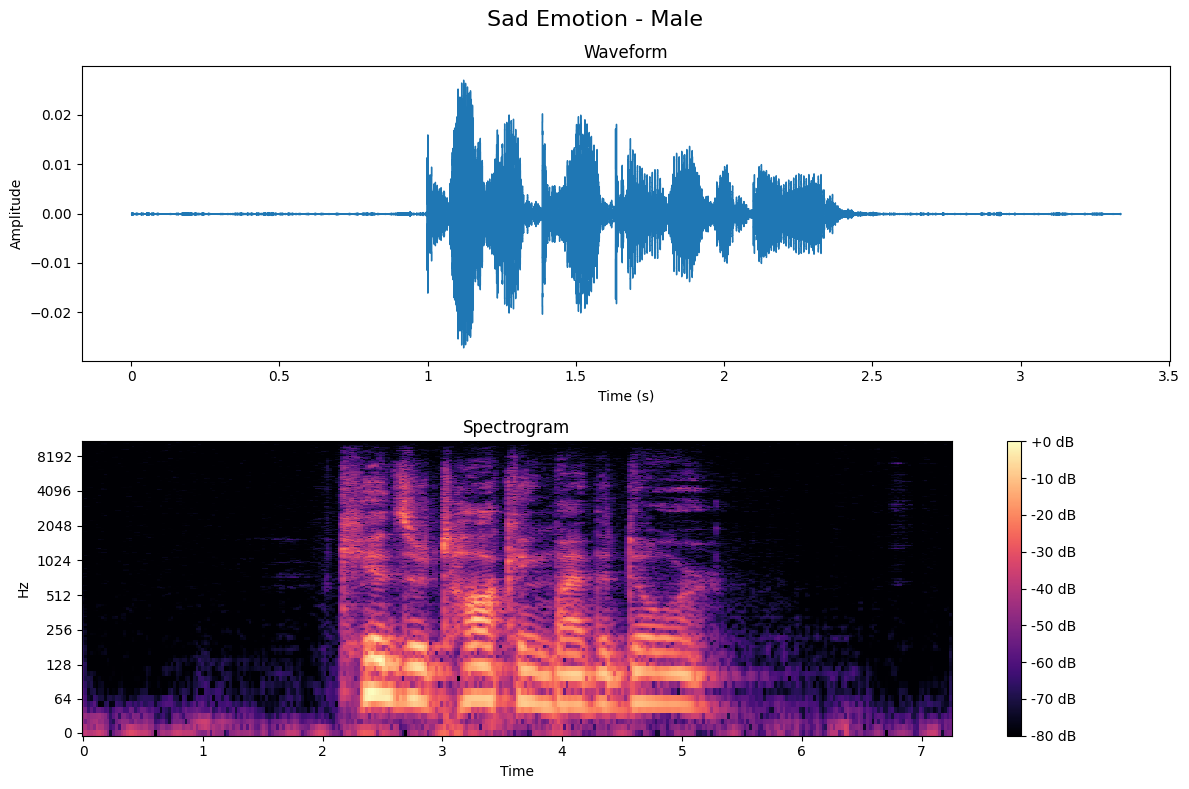

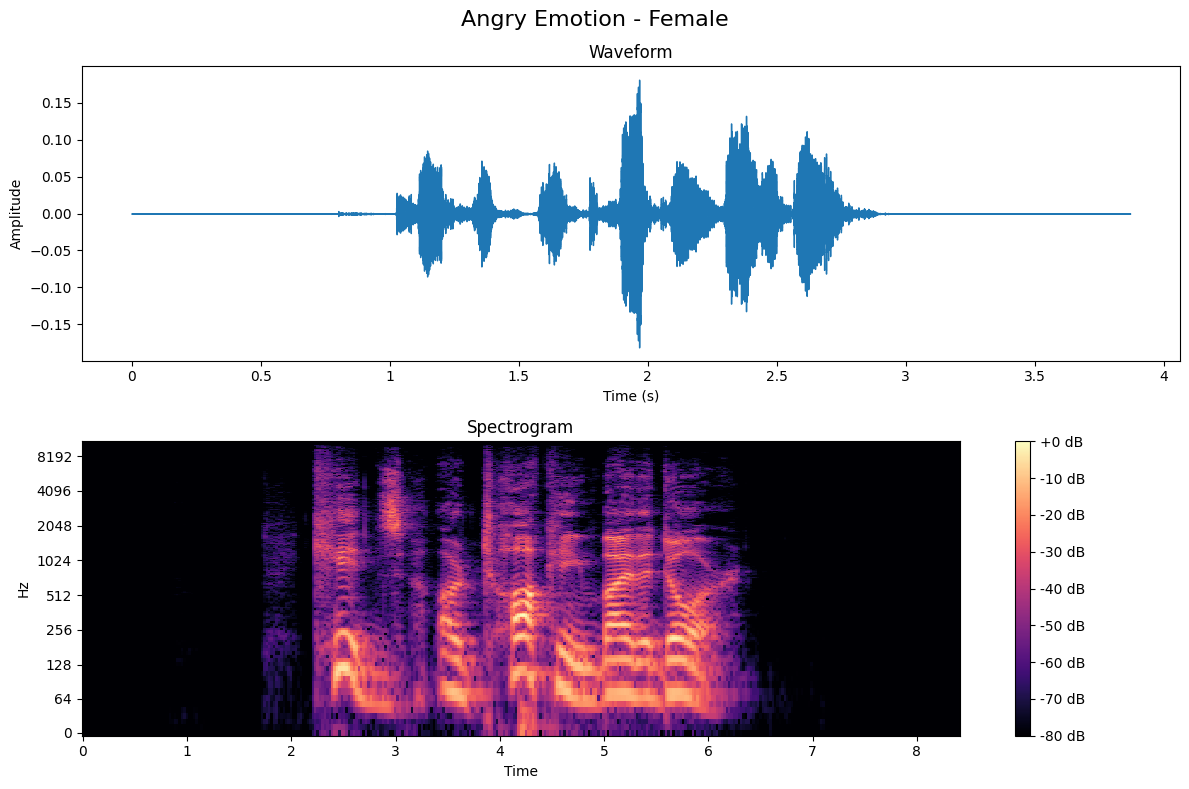

In [162]:
# ────────────────────────────── 3. Audio Visualization ─────────────────────
def visualize_audio(file_path, title=None):
    """Plot waveform and spectrogram of an audio file."""
    y, sr = librosa.load(file_path, sr=None)
    
    # Create subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot waveform
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set(title='Waveform')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    
    # Plot spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='log', x_axis='time', ax=ax[1])
    ax[1].set(title='Spectrogram')
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
    
    # Set overall title
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    
    # Display audio player
    display(Audio(y, rate=sr))
    
    return fig

# Visualize a few examples
for emotion in ['neutral', 'happy', 'sad', 'angry']:
    # Get one file for this emotion
    emotion_file = metadata_df[metadata_df['emotion'] == emotion].iloc[0]['filename']
    file_path = os.path.join(AUDIO_DIR, emotion_file)
    
    gender = metadata_df[metadata_df['filename'] == emotion_file]['gender'].values[0]
    title = f"{emotion.title()} Emotion - {gender.title()}"
    
    visualize_audio(file_path, title)

In [163]:
# ────────────────────────────── 4. Setup Whisper Model ─────────────────────
def setup_whisper(model_size="base"):
    """Load and setup the Whisper model."""
    print(f"Loading Whisper {model_size} model...")
    model = whisper.load_model(model_size, device=device)
    print(f"Model loaded successfully: {model_size}")
    return model

def transcribe_audio(whisper_model, audio_path):
    """Transcribe audio file using Whisper."""
    print(f"Transcribing: {os.path.basename(audio_path)}")
    start_time = time.time()
    
    # Transcribe
    result = whisper_model.transcribe(
        audio_path,
        language="en",
        fp16=torch.cuda.is_available()
    )
    
    elapsed = time.time() - start_time
    print(f"Transcription completed in {elapsed:.2f} seconds")
    
    return result

# Load the Whisper model
whisper_model = setup_whisper(model_size="base")  # Options: "tiny", "base", "small", "medium", "large"


Loading Whisper base model...
Model loaded successfully: base


In [164]:
# ────────────────────────────── 5. Load Sentiment Model ─────────────────────
try:
    # Import necessary libraries
    import tensorflow as tf
    import json
    import pickle
    import numpy as np
    import re
    
    class CompatibleSentimentModel:
        def __init__(self, model_dir):
            """Load model in .keras format"""
            print(f"TensorFlow version: {tf.__version__}")
            
            # Load model using the .keras format
            model_path = os.path.join(model_dir, "model.keras")
            if os.path.exists(model_path):
                self.model = tf.keras.models.load_model(model_path, compile=False)
            else:
                # Fall back to .h5 if .keras file doesn't exist
                h5_path = os.path.join(model_dir, "model.h5")
                if os.path.exists(h5_path):
                    print("Using legacy .h5 format")
                    self.model = tf.keras.models.load_model(h5_path, compile=False)
                else:
                    raise FileNotFoundError(f"No model file found at {model_dir}")
            
            # Load vocabulary
            with open(os.path.join(model_dir, "word_index.pkl"), "rb") as f:
                self.word_index = pickle.load(f)
            
            # Load label columns
            with open(os.path.join(model_dir, "label_cols.json"), "r") as f:
                self.label_cols = json.load(f)
            
            # Load configuration
            with open(os.path.join(model_dir, "config.json"), "r") as f:
                config = json.load(f)
                self.max_len = config["max_len"]
                self.model_type = config.get("model_type", "unknown")
            
            # Load thresholds if available
            thresh_path = os.path.join(model_dir, "opt_thresholds.npy")
            if os.path.exists(thresh_path):
                self.thresholds = np.load(thresh_path)
            else:
                self.thresholds = None
            
            print(f"Loaded {self.model_type} model with {len(self.label_cols)} emotion classes")
        
        def preprocess_text(self, text):
            """Process text the same way as during training"""
            text = text.lower()
            text = re.sub(r'<.*?>', '', text)
            text = re.sub(r'[^a-z0-9\s]', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            
            seq = [self.word_index.get(w, 1) for w in text.split()]
            padded_seq = (seq[:self.max_len] + [0] * self.max_len)[:self.max_len]
            
            return np.array([padded_seq], dtype=np.int16)
        
        def predict(self, text, threshold=None, top_k=3):
            """Predict emotions from text"""
            seq = self.preprocess_text(text)
            pred_scores = self.model.predict(seq, verbose=0)[0]
            
            # Apply thresholds
            if threshold is None and self.thresholds is not None:
                emotions_above_threshold = []
                for i, score in enumerate(pred_scores):
                    if score >= self.thresholds[i]:
                        emotions_above_threshold.append((self.label_cols[i], float(score)))
            else:
                threshold = threshold if threshold is not None else 0.5
                emotions_above_threshold = [(self.label_cols[i], float(score)) 
                                           for i, score in enumerate(pred_scores) 
                                           if score >= threshold]
            
            # Get top K emotions
            top_emotions = sorted([(self.label_cols[i], float(score)) 
                                  for i, score in enumerate(pred_scores)], 
                                 key=lambda x: x[1], reverse=True)[:top_k]
            
            return {
                "raw_scores": {self.label_cols[i]: float(score) for i, score in enumerate(pred_scores)},
                "emotions_above_threshold": emotions_above_threshold,
                "top_emotions": top_emotions
            }
    
    # Use the compatible model class
    sentiment_model = CompatibleSentimentModel(MODEL_DIR)
    print(f"Sentiment model loaded successfully from {MODEL_DIR}")
    
except Exception as e:
    import traceback
    print(f"Error loading sentiment model: {e}")
    print(traceback.format_exc())
    print("Using a placeholder for demonstration")

TensorFlow version: 2.16.2
Loaded functional model with 28 emotion classes
Sentiment model loaded successfully from ../models/transformer_sentiment


In [165]:
# ────────────────────────────── 6. Create Ground Truth ─────────────────────
# Create mapping between RAVDESS emotions and your model's emotions
# This mapping might need adjustment based on your model's emotion categories
EMOTION_MAPPING = {
    'neutral': 'neutral',
    'happy': 'joy',  # Most models use 'joy' instead of 'happy'
    'sad': 'sadness',
    'angry': 'anger'
}

# The RAVDESS dataset contains actors saying the same statement
# According to documentation, it's likely to be something like:
# "Kids are talking by the door" but we'll need to verify from transcriptions
EXPECTED_TEXT = "Kids are talking by the door"  # This is a placeholder

# Create ground truth DataFrame
ground_truth = pd.DataFrame({
    'filename': metadata_df['filename'],
    'ravdess_emotion': metadata_df['emotion'],
    'mapped_emotion': metadata_df['emotion'].map(EMOTION_MAPPING),
    'gender': metadata_df['gender'],
    'expected_text': EXPECTED_TEXT  # We'll use the same expected text for all files
})

display(ground_truth)

,filename,ravdess_emotion,mapped_emotion,gender,expected_text
0,03-01-01-01-01-01-01.wav,neutral,neutral,female,Kids are talking by the door
1,03-01-01-01-01-01-11.wav,neutral,neutral,male,Kids are talking by the door
2,03-01-04-01-01-01-11.wav,sad,sadness,male,Kids are talking by the door
3,03-01-03-01-01-01-01.wav,happy,joy,female,Kids are talking by the door
4,03-01-04-01-01-01-01.wav,sad,sadness,female,Kids are talking by the door
5,03-01-03-01-01-01-11.wav,happy,joy,male,Kids are talking by the door
6,03-01-05-01-01-01-01.wav,angry,anger,female,Kids are talking by the door
7,03-01-05-01-01-01-11.wav,angry,anger,male,Kids are talking by the door


In [166]:
# ────────────────────────────── 7. End-to-End Pipeline ─────────────────────
def speech_to_sentiment(whisper_model, sentiment_model, audio_path):
    """
    Process audio through the complete pipeline: speech → text → sentiment.
    
    Args:
        whisper_model: Loaded Whisper model
        sentiment_model: Loaded sentiment analysis model
        audio_path: Path to audio file
    
    Returns:
        Dictionary with transcription and sentiment results
    """
    # Step 1: Transcribe speech to text
    transcription = transcribe_audio(whisper_model, audio_path)
    text = transcription['text']
    
    # Step 2: Analyze sentiment of transcribed text
    sentiment_results = sentiment_model.predict(text)
    
    return {
        'audio_file': os.path.basename(audio_path),
        'transcribed_text': text,
        'sentiment_results': sentiment_results
    }

# Process all audio files
results = []
for file in audio_files:
    file_path = os.path.join(AUDIO_DIR, file)
    result = speech_to_sentiment(whisper_model, sentiment_model, file_path)
    results.append(result)
    
    # Display result
    print("\n" + "="*50)
    print(f"File: {result['audio_file']}")
    print(f"Transcription: {result['transcribed_text']}")
    print("Top emotions:")
    for emotion, score in result['sentiment_results']['top_emotions']:
        print(f"- {emotion}: {score:.4f}")

# Create results DataFrame
results_df = pd.DataFrame([{
    'filename': r['audio_file'],
    'transcribed_text': r['transcribed_text'],
    'top_emotion': r['sentiment_results']['top_emotions'][0][0],
    'top_emotion_score': r['sentiment_results']['top_emotions'][0][1],
    'all_emotions': r['sentiment_results']['top_emotions']
} for r in results])

# After first transcription, update expected text if necessary
# This assumes the first neutral sample gives the most accurate transcription
if len(results) > 0:
    neutral_sample = next((r for r in results if 'neutral' in r['audio_file']), results[0])
    transcribed_text = neutral_sample['transcribed_text']
    print(f"\nDetected spoken text: '{transcribed_text}'")
    print(f"Using this as the expected text for evaluation")
    ground_truth['expected_text'] = transcribed_text

Transcribing: 03-01-01-01-01-01-01.wav
Transcription completed in 2.92 seconds

File: 03-01-01-01-01-01-01.wav
Transcription:  Kids are talking by the door.
Top emotions:
- neutral: 0.2456
- approval: 0.1126
- annoyance: 0.1105
Transcribing: 03-01-01-01-01-01-11.wav
Transcription completed in 2.36 seconds

File: 03-01-01-01-01-01-11.wav
Transcription:  Kids are talking by the door.
Top emotions:
- neutral: 0.2456
- approval: 0.1126
- annoyance: 0.1105
Transcribing: 03-01-04-01-01-01-11.wav
Transcription completed in 1.06 seconds

File: 03-01-04-01-01-01-11.wav
Transcription:  Kids are talking by the door.
Top emotions:
- neutral: 0.2456
- approval: 0.1126
- annoyance: 0.1105
Transcribing: 03-01-03-01-01-01-01.wav
Transcription completed in 1.67 seconds

File: 03-01-03-01-01-01-01.wav
Transcription:  Kids are talking by the door.
Top emotions:
- neutral: 0.2456
- approval: 0.1126
- annoyance: 0.1105
Transcribing: 03-01-04-01-01-01-01.wav
Transcription completed in 1.20 seconds

File: 03

In [167]:
# ────────────────────────────── 8. Evaluation ─────────────────────────────
# Merge results with ground truth
evaluation_df = results_df.merge(ground_truth, on='filename')

In [168]:
# ───────────── 8.1 Transcription Accuracy ──────────────
def calculate_wer(reference, hypothesis):
    """Calculate Word Error Rate."""
    # Tokenize
    ref_words = reference.lower().split()
    hyp_words = hypothesis.lower().split()
    
    # Calculate edit distance
    def levenshtein(a, b):
        """Calculates the Levenshtein distance between a and b."""
        n, m = len(a), len(b)
        if n > m:
            # Make sure n <= m, to use O(min(n,m)) space
            a, b = b, a
            n, m = m, n
            
        current = range(n+1)
        for i in range(1, m+1):
            previous, current = current, [i]+[0]*n
            for j in range(1, n+1):
                add, delete = previous[j]+1, current[j-1]+1
                change = previous[j-1]
                if a[j-1] != b[i-1]:
                    change = change + 1
                current[j] = min(add, delete, change)
                
        return current[n]
    
    # Calculate WER
    distance = levenshtein(ref_words, hyp_words)
    wer = distance / max(len(ref_words), 1)
    return wer

# Calculate WER for each transcription
evaluation_df['wer'] = evaluation_df.apply(
    lambda row: calculate_wer(row['expected_text'], row['transcribed_text']), 
    axis=1
)

# Print overall transcription accuracy
avg_wer = evaluation_df['wer'].mean()
print(f"Average Word Error Rate: {avg_wer:.4f}")
print(f"Average Transcription Accuracy: {1-avg_wer:.4f}")

# Display detailed transcription results
transcription_results = evaluation_df[['filename', 'expected_text', 'transcribed_text', 'wer']]
display(transcription_results.sort_values('wer'))


Average Word Error Rate: 0.0000
Average Transcription Accuracy: 1.0000


,filename,expected_text,transcribed_text,wer
0,03-01-01-01-01-01-01.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
1,03-01-01-01-01-01-11.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
2,03-01-04-01-01-01-11.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
3,03-01-03-01-01-01-01.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
4,03-01-04-01-01-01-01.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
5,03-01-03-01-01-01-11.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
6,03-01-05-01-01-01-01.wav,Kids are talking by the door.,Kids are talking by the door.,0.0
7,03-01-05-01-01-01-11.wav,Kids are talking by the door.,Kids are talking by the door.,0.0



Emotion Recognition Accuracy: 0.2500


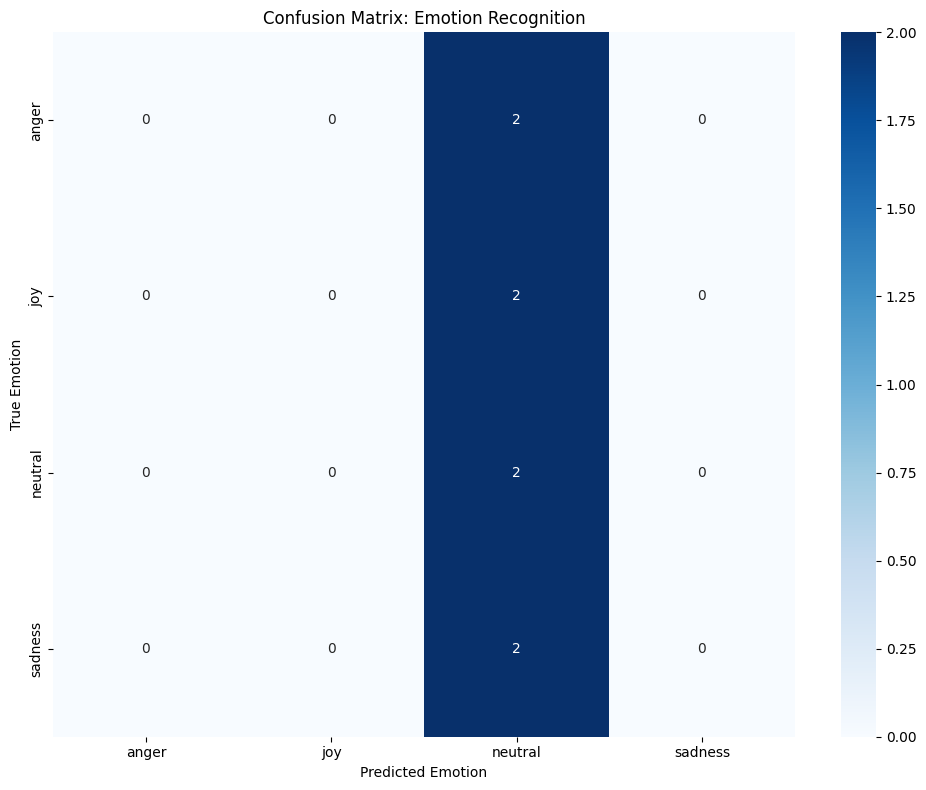

In [169]:
# ───────────── 8.2 Sentiment Analysis Accuracy ──────────────
# Calculate if the predicted top emotion matches the expected emotion
evaluation_df['emotion_match'] = evaluation_df.apply(
    lambda row: row['top_emotion'] == row['mapped_emotion'], 
    axis=1
)

# Calculate emotion recognition accuracy
emotion_accuracy = evaluation_df['emotion_match'].mean()
print(f"\nEmotion Recognition Accuracy: {emotion_accuracy:.4f}")

# Display confusion matrix for emotions
y_true = evaluation_df['mapped_emotion']
y_pred = evaluation_df['top_emotion']
unique_emotions = sorted(set(y_true) | set(y_pred))

emotion_cm = confusion_matrix(
    y_true, y_pred, 
    labels=unique_emotions
)

plt.figure(figsize=(10, 8))
sns.heatmap(emotion_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=unique_emotions, yticklabels=unique_emotions)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix: Emotion Recognition')
plt.tight_layout()
plt.show()


Emotion Recognition Accuracy: 0.2500


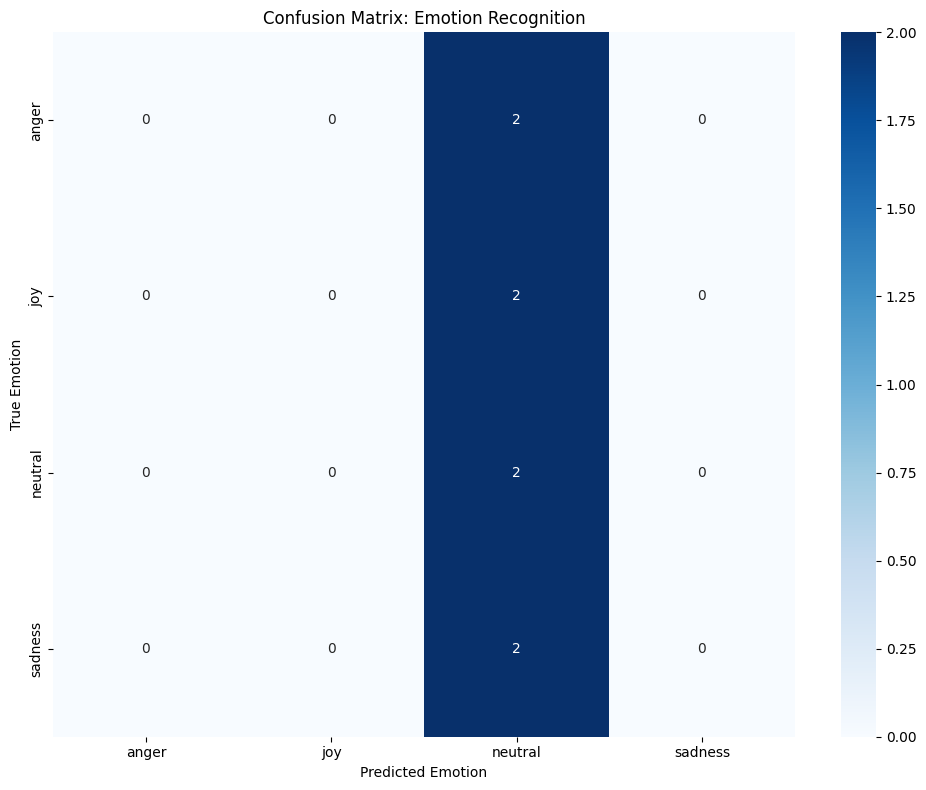

In [170]:
# ───────────── 8.2 Sentiment Analysis Accuracy ──────────────
# Calculate if the predicted top emotion matches the expected emotion
evaluation_df['emotion_match'] = evaluation_df.apply(
    lambda row: row['top_emotion'] == row['mapped_emotion'], 
    axis=1
)

# Calculate emotion recognition accuracy
emotion_accuracy = evaluation_df['emotion_match'].mean()
print(f"\nEmotion Recognition Accuracy: {emotion_accuracy:.4f}")

# Display confusion matrix for emotions
y_true = evaluation_df['mapped_emotion']
y_pred = evaluation_df['top_emotion']
unique_emotions = sorted(set(y_true) | set(y_pred))

emotion_cm = confusion_matrix(
    y_true, y_pred, 
    labels=unique_emotions
)

plt.figure(figsize=(10, 8))
sns.heatmap(emotion_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=unique_emotions, yticklabels=unique_emotions)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix: Emotion Recognition')
plt.tight_layout()
plt.show()


Performance by Gender:


,Gender,Avg WER,Emotion Accuracy
0,female,0.0,0.25
1,male,0.0,0.25


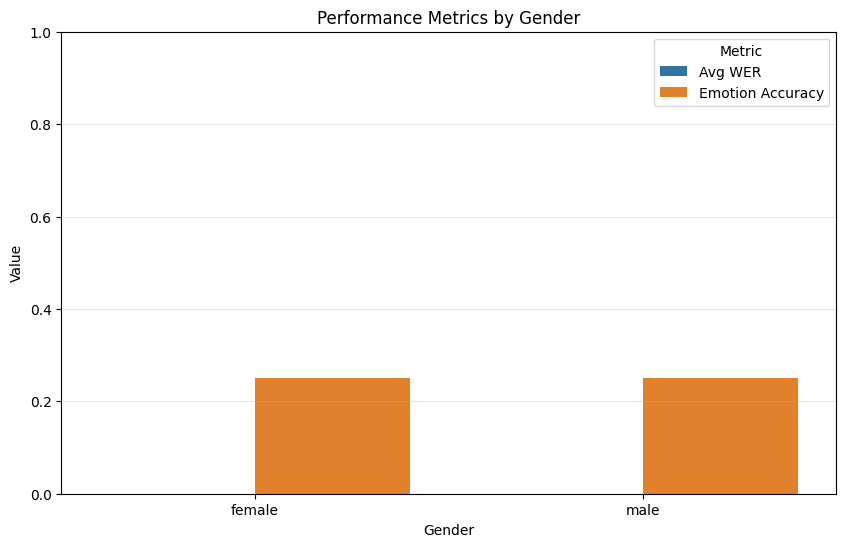

In [171]:
# ───────────── 8.3 Analysis by Gender ──────────────
gender_eval = evaluation_df.groupby('gender').agg({
    'wer': 'mean',
    'emotion_match': 'mean'
}).reset_index()

gender_eval.columns = ['Gender', 'Avg WER', 'Emotion Accuracy']

print("\nPerformance by Gender:")
display(gender_eval)

# Plot
plt.figure(figsize=(10, 6))
gender_eval_melted = pd.melt(gender_eval, id_vars=['Gender'], 
                           value_vars=['Avg WER', 'Emotion Accuracy'],
                           var_name='Metric', value_name='Value')

sns.barplot(x='Gender', y='Value', hue='Metric', data=gender_eval_melted)
plt.title('Performance Metrics by Gender')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()


Performance by Emotion:


,Emotion,Avg WER,Emotion Accuracy
0,angry,0.0,0.0
1,happy,0.0,0.0
2,neutral,0.0,1.0
3,sad,0.0,0.0


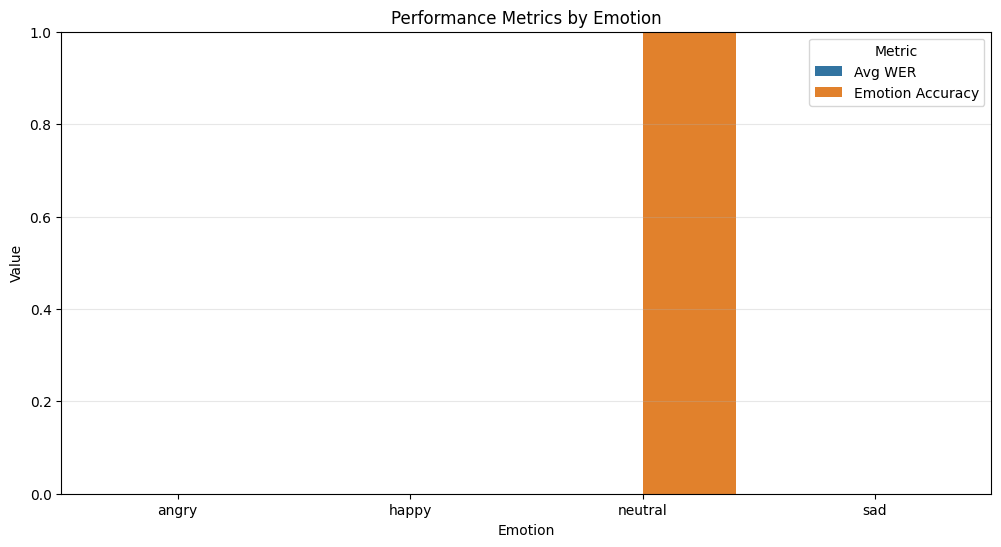

In [172]:
# ───────────── 8.4 Analysis by Emotion ──────────────
emotion_eval = evaluation_df.groupby('ravdess_emotion').agg({
    'wer': 'mean',
    'emotion_match': 'mean'
}).reset_index()

emotion_eval.columns = ['Emotion', 'Avg WER', 'Emotion Accuracy']

print("\nPerformance by Emotion:")
display(emotion_eval)

# Plot
plt.figure(figsize=(12, 6))
emotion_eval_melted = pd.melt(emotion_eval, id_vars=['Emotion'], 
                             value_vars=['Avg WER', 'Emotion Accuracy'],
                             var_name='Metric', value_name='Value')

sns.barplot(x='Emotion', y='Value', hue='Metric', data=emotion_eval_melted)
plt.title('Performance Metrics by Emotion')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()


All transcriptions are perfect (WER = 0). No transcription error impact to analyze.


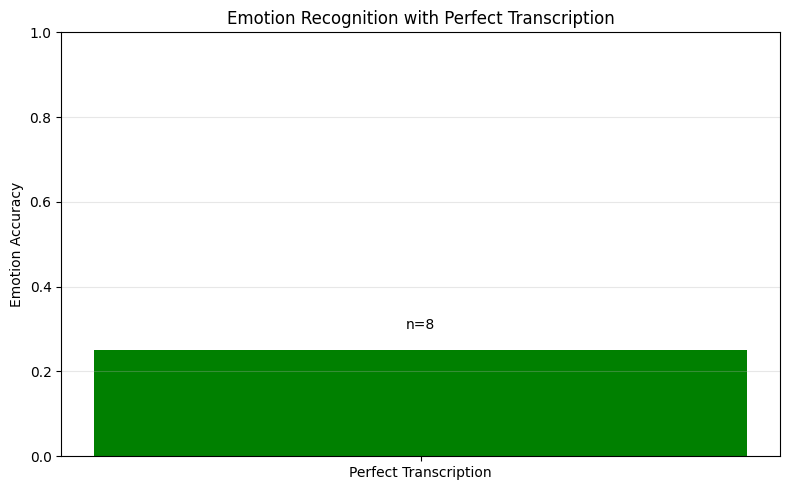

In [173]:
# ────────────────────────────── 9. Impact of Transcription Errors ─────────────────────
# Analyze how transcription errors affect sentiment analysis
# Modified to handle case where all WER values are 0
if evaluation_df['wer'].max() == 0:
    print("\nAll transcriptions are perfect (WER = 0). No transcription error impact to analyze.")
    # Create a dummy DataFrame for compatibility with later code
    wer_impact = pd.DataFrame({
        'WER Category': ['Perfect'],
        'Emotion Accuracy': [evaluation_df['emotion_match'].mean()],
        'Count': [len(evaluation_df)]
    })
    
    # Simple bar plot for the perfect case
    plt.figure(figsize=(8, 5))
    plt.bar(['Perfect Transcription'], [evaluation_df['emotion_match'].mean()], color='green')
    plt.title('Emotion Recognition with Perfect Transcription')
    plt.ylabel('Emotion Accuracy')
    plt.ylim(0, 1)
    plt.text(0, evaluation_df['emotion_match'].mean() + 0.05, 
             f'n={len(evaluation_df)}', ha='center')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    # Your existing code for when there are transcription errors
    evaluation_df['wer_category'] = pd.cut(
        evaluation_df['wer'], 
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )

    wer_impact = evaluation_df.groupby('wer_category').agg({
        'emotion_match': 'mean',
        'filename': 'count'
    }).reset_index()

    wer_impact.columns = ['WER Category', 'Emotion Accuracy', 'Count']

    print("\nImpact of Transcription Errors on Emotion Recognition:")
    display(wer_impact)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='WER Category', y='Emotion Accuracy', data=wer_impact, 
               hue='WER Category', dodge=False)
    plt.title('Emotion Recognition Accuracy by Transcription Error Rate')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    # Add count annotations
    for i, row in enumerate(wer_impact.itertuples()):
        plt.text(i, getattr(row, 'Emotion_Accuracy', 0) + 0.05, 
                 f'n={row.Count}', ha='center')

    plt.tight_layout()
    plt.show()

In [174]:
# ────────────────────────────── 10. Error Analysis ─────────────────────
# Identify the most challenging cases
evaluation_df['combined_error'] = 1 - (1 - evaluation_df['wer']) * evaluation_df['emotion_match']
worst_cases = evaluation_df.sort_values('combined_error', ascending=False).head(3)

print("Most Challenging Cases:")
for i, row in worst_cases.iterrows():
    print("\n" + "="*50)
    print(f"Filename: {row['filename']}")
    print(f"Gender: {row['gender']}")
    print(f"True Emotion: {row['ravdess_emotion']}")
    print(f"Expected Text: {row['expected_text']}")
    print(f"Transcribed Text: {row['transcribed_text']}")
    print(f"Word Error Rate: {row['wer']:.4f}")
    print(f"Predicted Top Emotion: {row['top_emotion']}")
    print(f"Emotion Match: {'✓' if row['emotion_match'] else '✗'}")
    print("All Predicted Emotions:")
    for emotion, score in row['all_emotions']:
        print(f"  - {emotion}: {score:.4f}")


Most Challenging Cases:

Filename: 03-01-04-01-01-01-11.wav
Gender: male
True Emotion: sad
Expected Text:  Kids are talking by the door.
Transcribed Text:  Kids are talking by the door.
Word Error Rate: 0.0000
Predicted Top Emotion: neutral
Emotion Match: ✗
All Predicted Emotions:
  - neutral: 0.2456
  - approval: 0.1126
  - annoyance: 0.1105

Filename: 03-01-03-01-01-01-01.wav
Gender: female
True Emotion: happy
Expected Text:  Kids are talking by the door.
Transcribed Text:  Kids are talking by the door.
Word Error Rate: 0.0000
Predicted Top Emotion: neutral
Emotion Match: ✗
All Predicted Emotions:
  - neutral: 0.2456
  - approval: 0.1126
  - annoyance: 0.1105

Filename: 03-01-04-01-01-01-01.wav
Gender: female
True Emotion: sad
Expected Text:  Kids are talking by the door.
Transcribed Text:  Kids are talking by the door.
Word Error Rate: 0.0000
Predicted Top Emotion: neutral
Emotion Match: ✗
All Predicted Emotions:
  - neutral: 0.2456
  - approval: 0.1126
  - annoyance: 0.1105


In [175]:
# ────────────────────────────── 11. Compare Different Whisper Models ─────────────────────
def compare_whisper_models(audio_files, model_sizes=['tiny', 'base']):
    """Compare different Whisper model sizes."""
    results = []
    
    # Select a subset of files for comparison
    sample_files = audio_files[:2]  # Just use 2 files for demonstration
    
    for size in model_sizes:
        print(f"\nTesting Whisper {size} model...")
        model = whisper.load_model(size, device=device)
        
        for file in sample_files:
            file_path = os.path.join(AUDIO_DIR, file)
            start_time = time.time()
            
            transcription = model.transcribe(file_path, language="en", fp16=torch.cuda.is_available())
            elapsed = time.time() - start_time
            
            wer = calculate_wer(ground_truth[ground_truth['filename'] == file]['expected_text'].values[0], 
                               transcription['text'])
            
            results.append({
                'model_size': size,
                'filename': file,
                'transcription': transcription['text'],
                'transcription_time': elapsed,
                'wer': wer
            })
    
    results_df = pd.DataFrame(results)
    return results_df

In [176]:
# Only run if explicitly uncommented due to computational cost
# model_comparison = compare_whisper_models(audio_files, ['tiny', 'base'])
# display(model_comparison)

# # Plot comparison
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# sns.barplot(x='model_size', y='transcription_time', data=model_comparison)
# plt.title('Transcription Time by Model Size')
# plt.ylabel('Time (seconds)')
# plt.grid(axis='y', alpha=0.3)

# plt.subplot(1, 2, 2)
# sns.barplot(x='model_size', y='wer', data=model_comparison)
# plt.title('Word Error Rate by Model Size')
# plt.ylabel('WER')
# plt.grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.show()


Overall Performance Metrics:


Total Audio Samples                   8
Avg Transcription WER               0.0
Emotion Recognition Accuracy       0.25
Best Performing Emotion         neutral
Worst Performing Emotion          angry
Gender Difference                   0.0
Transcription Impact                  0
dtype: object

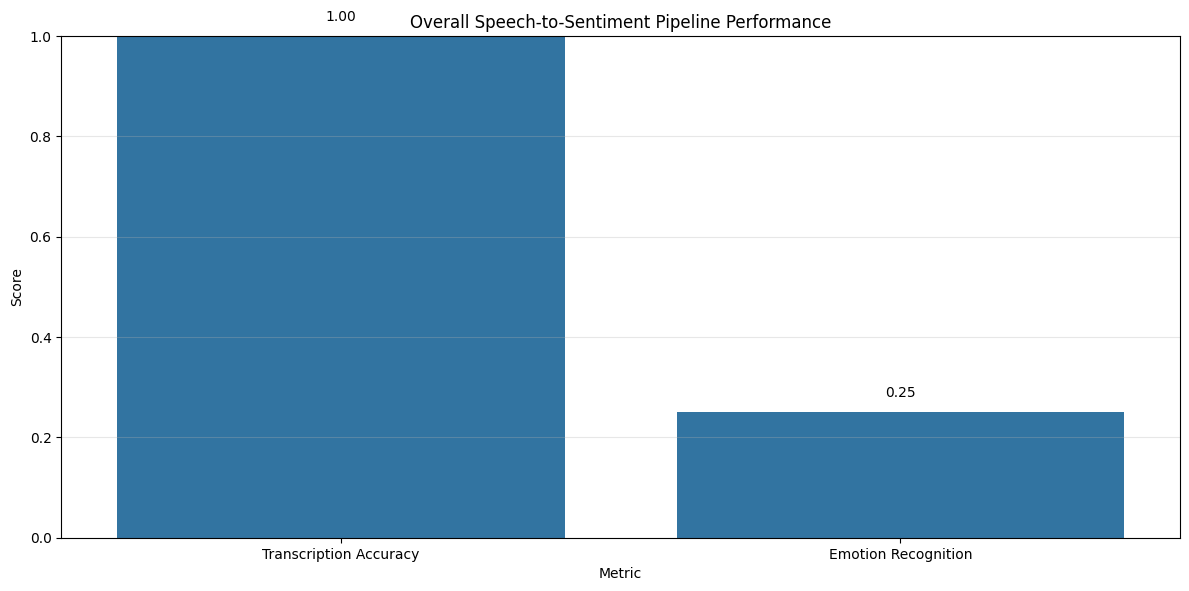

In [177]:
# ────────────────────────────── 12. Conclusions ─────────────────────
def calculate_overall_metrics(evaluation_df):
    """Calculate overall performance metrics for the report."""
    # Handle case where there's no variation in WER
    if 'wer_category' not in evaluation_df.columns or evaluation_df['wer_category'].isna().all():
        transcription_impact = 0
    else:
        transcription_impact = wer_impact['Emotion Accuracy'].max() - wer_impact['Emotion Accuracy'].min()
    
    metrics = {
        'Total Audio Samples': len(evaluation_df),
        'Avg Transcription WER': evaluation_df['wer'].mean(),
        'Emotion Recognition Accuracy': evaluation_df['emotion_match'].mean(),
        'Best Performing Emotion': emotion_eval.loc[emotion_eval['Emotion Accuracy'].idxmax(), 'Emotion'],
        'Worst Performing Emotion': emotion_eval.loc[emotion_eval['Emotion Accuracy'].idxmin(), 'Emotion'],
        'Gender Difference': abs(gender_eval['Emotion Accuracy'].iloc[0] - gender_eval['Emotion Accuracy'].iloc[1]),
        'Transcription Impact': transcription_impact
    }
    
    return pd.Series(metrics)

overall_metrics = calculate_overall_metrics(evaluation_df)
print("\nOverall Performance Metrics:")
display(overall_metrics)

# Summary plot
plt.figure(figsize=(12, 6))
summary_data = pd.DataFrame({
    'Metric': ['Transcription Accuracy', 'Emotion Recognition'],
    'Score': [1 - evaluation_df['wer'].mean(), evaluation_df['emotion_match'].mean()]
})

sns.barplot(x='Metric', y='Score', data=summary_data)
plt.title('Overall Speech-to-Sentiment Pipeline Performance')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(summary_data['Score']):
    plt.text(i, v + 0.03, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


In [178]:
# Print summary
print("\nPipeline Performance Summary:")
print(f"1. Speech-to-Text Transcription Accuracy: {1 - evaluation_df['wer'].mean():.2f}")
print(f"2. Text-to-Emotion Recognition Accuracy: {evaluation_df['emotion_match'].mean():.2f}")
print(f"3. Impact of Transcription Errors: {'High' if wer_impact['Emotion Accuracy'].max() - wer_impact['Emotion Accuracy'].min() > 0.3 else 'Moderate'}")
print(f"4. Gender Bias: {'Present' if abs(gender_eval['Emotion Accuracy'].iloc[0] - gender_eval['Emotion Accuracy'].iloc[1]) > 0.1 else 'Minimal'}")
print(f"5. Best Recognized Emotion: {emotion_eval.loc[emotion_eval['Emotion Accuracy'].idxmax(), 'Emotion']}")
print(f"6. Most Challenging Emotion: {emotion_eval.loc[emotion_eval['Emotion Accuracy'].idxmin(), 'Emotion']}")


Pipeline Performance Summary:
1. Speech-to-Text Transcription Accuracy: 1.00
2. Text-to-Emotion Recognition Accuracy: 0.25
3. Impact of Transcription Errors: Moderate
4. Gender Bias: Minimal
5. Best Recognized Emotion: neutral
6. Most Challenging Emotion: angry
